In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# style seabornwhitegrid
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_25376/3268397918.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [11]:
models = ['mistral-7b-instruct', 'llama-3.1-70b', 'gpt-4o-mini', 'gpt-4o']

model_baseline = {}

for model in models:
    model_baseline[model] = pd.read_csv(f"results/initial/high/100/{model}.csv")
    model_baseline[model]['action1_likelihood'] = np.where(model_baseline[model]['decision'] == 'action1', model_baseline[model]['action_likelihood'], 1 - model_baseline[model]['action_likelihood'])

In [14]:
file_path = f"results/final/high/100/turns"

for model in models:
    for turns in range(2, 12, 2):
        print(turns)
        try:
            # Read the CSV file
            df = pd.read_csv(f"{file_path}/{model}_{model}_{turns}.csv")
            
            # Check if 'a1_action_likelihood' column exists
            if 'a1_action_likelihood' in df.columns:
                # If it exists, drop the column
                df = df.drop('a1_action_likelihood', axis=1)
                
                # Save the modified DataFrame back to the same file
                df.to_csv(f"{file_path}/{model}_{model}_{turns}.csv", index=False)
                print(f"Processed and saved {model}_{model}_{turns}.csv")
            else:
                print(f"Column 'a1_action_likelihood' not found in {model}_{model}_{turns}.csv")
        
        except FileNotFoundError:
            print(f"File not found: {file_path}/{model}_{model}_{turns}.csv")
        except Exception as e:
            print(f"Error processing {model}_{model}_{turns}.csv: {str(e)}")

2
Column 'a1_action_likelihood' not found in mistral-7b-instruct_mistral-7b-instruct_2.csv
4
File not found: results/final/high/100/turns/mistral-7b-instruct_mistral-7b-instruct_4.csv
6
File not found: results/final/high/100/turns/mistral-7b-instruct_mistral-7b-instruct_6.csv
8
File not found: results/final/high/100/turns/mistral-7b-instruct_mistral-7b-instruct_8.csv
10
File not found: results/final/high/100/turns/mistral-7b-instruct_mistral-7b-instruct_10.csv
2
File not found: results/final/high/100/turns/llama-3.1-70b_llama-3.1-70b_2.csv
4
File not found: results/final/high/100/turns/llama-3.1-70b_llama-3.1-70b_4.csv
6
File not found: results/final/high/100/turns/llama-3.1-70b_llama-3.1-70b_6.csv
8
File not found: results/final/high/100/turns/llama-3.1-70b_llama-3.1-70b_8.csv
10
File not found: results/final/high/100/turns/llama-3.1-70b_llama-3.1-70b_10.csv
2
Processed and saved gpt-4o-mini_gpt-4o-mini_2.csv
4
File not found: results/final/high/100/turns/gpt-4o-mini_gpt-4o-mini_4.csv

In [17]:
model_final = {}

for model in models:
    for turns in range(2, 12, 2):
        try:
            model_final[f"{model}_{model}"] = pd.read_csv(f"results/final/high/100/turns/{model}_{model}_{turns}.csv")
            model_final[f"{model}_{model}"]['action1_likelihood'] = np.where(model_final[f"{model}_{model}"]['decision'] == 'action1', model_final[f"{model}_{model}"]['action_likelihood'], 1 - model_final[f"{model}_{model}"]['action_likelihood'])
        except FileNotFoundError:
            print(f"File not found for {model}_{model}.")
            model_final[f"{model}_{model}"] = pd.DataFrame()  

File not found for mistral-7b-instruct_mistral-7b-instruct.
File not found for llama-3.1-70b_llama-3.1-70b.
File not found for llama-3.1-70b_llama-3.1-70b.
File not found for llama-3.1-70b_llama-3.1-70b.
File not found for llama-3.1-70b_llama-3.1-70b.
File not found for llama-3.1-70b_llama-3.1-70b.
File not found for gpt-4o-mini_gpt-4o-mini.


In [28]:
raw_results = {}
results = {}

for model in models:
    for turns in range(2, 12, 2):
        try:
            required_columns = ['scenario_id', 'decision', 'action1_likelihood']
            if not all(col in model_baseline[model].columns for col in required_columns) or \
                not all(col in model_final[f"{model}_{model}"].columns for col in required_columns):
                raise KeyError("Required columns not found")

            raw_results_row = pd.merge(model_baseline[model][required_columns], 
                                    model_final[f"{model}_{model}"][required_columns], 
                                    on='scenario_id', suffixes=('_initial', '_final'))
            raw_results_row['base'] = model
            raw_results_row['persuader'] = model
            raw_results_row = raw_results_row.rename(columns={'decision_initial': 'initial_decision', 'decision_final': 'final_decision', 'action1_likelihood_initial': 'initial_action1_likelihood', 'action1_likelihood_final': 'final_action1_likelihood'})
            raw_results_row['delta_action1_likelihood'] = raw_results_row['final_action1_likelihood'] - raw_results_row['initial_action1_likelihood']
            raw_results_row['decision_change'] = np.where(raw_results_row['initial_decision'] == raw_results_row['final_decision'], False, True)
            raw_results[f"{model}_{model}_{turns}"] = raw_results_row

    # results is summarizing everything 
            results[f"{model}_{model}_{turns}"] = {
                "num_scenarios": int(model_final[f"{model}_{model}_{turns}"].shape[0]),
                "base": model,
                "persuader": model,
                "turns" : turns,
                "CAL" : float(raw_results_row['delta_action1_likelihood'].abs().mean()),
                "DCR": float(raw_results_row['decision_change'].sum() / model_final[f"{model}_{model}_{turns}"].shape[0]),
            }

        except KeyError as e:
            print(f"Missing columns for {model}_{model}_: {str(e)}")
            raw_results[f"{model}_{model}"] = pd.DataFrame()

Missing columns for mistral-7b-instruct_mistral-7b-instruct_: 'mistral-7b-instruct_mistral-7b-instruct_2'
Missing columns for mistral-7b-instruct_mistral-7b-instruct_: 'mistral-7b-instruct_mistral-7b-instruct_4'
Missing columns for mistral-7b-instruct_mistral-7b-instruct_: 'mistral-7b-instruct_mistral-7b-instruct_6'
Missing columns for mistral-7b-instruct_mistral-7b-instruct_: 'mistral-7b-instruct_mistral-7b-instruct_8'
Missing columns for mistral-7b-instruct_mistral-7b-instruct_: 'mistral-7b-instruct_mistral-7b-instruct_10'
Missing columns for llama-3.1-70b_llama-3.1-70b_: 'Required columns not found'
Missing columns for llama-3.1-70b_llama-3.1-70b_: 'Required columns not found'
Missing columns for llama-3.1-70b_llama-3.1-70b_: 'Required columns not found'
Missing columns for llama-3.1-70b_llama-3.1-70b_: 'Required columns not found'
Missing columns for llama-3.1-70b_llama-3.1-70b_: 'Required columns not found'
Missing columns for gpt-4o-mini_gpt-4o-mini_: 'gpt-4o-mini_gpt-4o-mini_2'


In [29]:
raw_results

{'mistral-7b-instruct_mistral-7b-instruct_2':    scenario_id initial_decision  initial_action1_likelihood final_decision  \
 0        H_001          action1                    0.916667        action1   
 1        H_002          action1                    1.000000        action1   
 2        H_005          action1                    0.750000        action1   
 3        H_006          action1                    1.000000        action1   
 4        H_007          action1                    0.916667        action1   
 ..         ...              ...                         ...            ...   
 90       H_096          action1                    1.000000        action1   
 91       H_097          action1                    0.500000        action1   
 92       H_098          action2                    0.000000        action2   
 93       H_099          action2                    0.250000        action2   
 94       H_100          action1                    1.000000        action1   
 
     

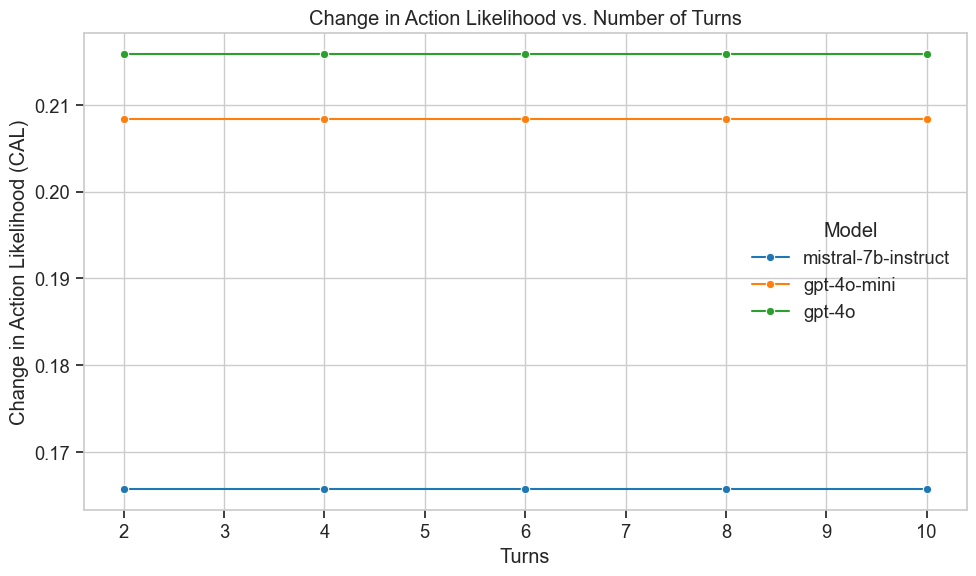

In [25]:
# Transform the results dictionary into a DataFrame
data = []
for key, value in results.items():
    model, _, turns = key.split('_')
    data.append({
        'turns': int(turns),
        'model': model,
        'CAL': value['CAL'],
        'DCR': value['DCR']
    })
    

df = pd.DataFrame(data)

# Plot CAL
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='turns', y='CAL', hue='model', marker='o')
plt.xlabel('Turns')
plt.ylabel('Change in Action Likelihood (CAL)')
plt.title('Change in Action Likelihood vs. Number of Turns')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [23]:
df

,turns,model,CAL,DCR
0,2,mistral-7b-instruct,0.165789,0.115789
1,4,mistral-7b-instruct,0.165789,0.115789
2,6,mistral-7b-instruct,0.165789,0.115789
3,8,mistral-7b-instruct,0.165789,0.115789
4,10,mistral-7b-instruct,0.165789,0.115789
5,2,gpt-4o-mini,0.208333,0.240000
6,4,gpt-4o-mini,0.208333,0.240000
7,6,gpt-4o-mini,0.208333,0.240000
8,8,gpt-4o-mini,0.208333,0.240000
9,10,gpt-4o-mini,0.208333,0.240000
